### Using Linear and Random Forest Regressors to Predict Book Ranks

In [16]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import time
pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 300)
from textblob import TextBlob
from sklearn.linear_model import Ridge
from matplotlib import pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import zipfile
import urllib
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

### Read in Review Dataset

In [18]:
url = urlopen("https://github.com/jitsen-design/Data-607-Final-Project/blob/reviews/data/review_final.csv.zip?raw=true")
#Download Zipfile and create pandas DataFrame
zipfile = ZipFile(BytesIO(url.read()))
df = pd.read_csv(zipfile.open('review_final.csv'))

In [19]:
final_df = df[(~df['review_text'].isnull())]
final_df = final_df[(final_df['review_text'].apply(lambda x: len(x)>0))]

In [26]:
final_df['title'].nunique()

477

### Calculate Sentiment

In [21]:
final_df['sentiment'] = final_df['review_text'].apply(lambda x: TextBlob(x).polarity)

### Calculate length of review

In [22]:
final_df['review_length'] = final_df['review_text'].apply(lambda x: len(x))

In [23]:
final_df['list_date'] = pd.to_datetime(final_df['list_date']).apply(lambda x: x.timestamp())

In [24]:
filter_df = final_df[final_df['rank'] == final_df.groupby(['primary_isbn10'])['rank'].transform(max)]

In [27]:
len(filter_df)

1325

### Fit Regression Model and Get R^2 and Adjusted R^2

In [28]:
model_df = filter_df[['rank', 
                      'weeks_on_list',
                      'publisher',
                      'list_title',
                      'sentiment',
                      'review_length']]

df_dummy = pd.get_dummies(model_df, 
                          drop_first=False, 
                          columns=['publisher',
                                   'list_title'])

stats_model = Ridge(fit_intercept=True, 
                    normalize=True)
X = df_dummy.drop(labels=['rank'],
                  axis=1)
y = df_dummy['rank'] 
stats_model.fit(X, y)
df_dummy['pred_rank'] = stats_model.predict(X)
stats_model.score(X, y), 1 - (1-stats_model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)

(0.4606378282726052, 0.36466591159513273)

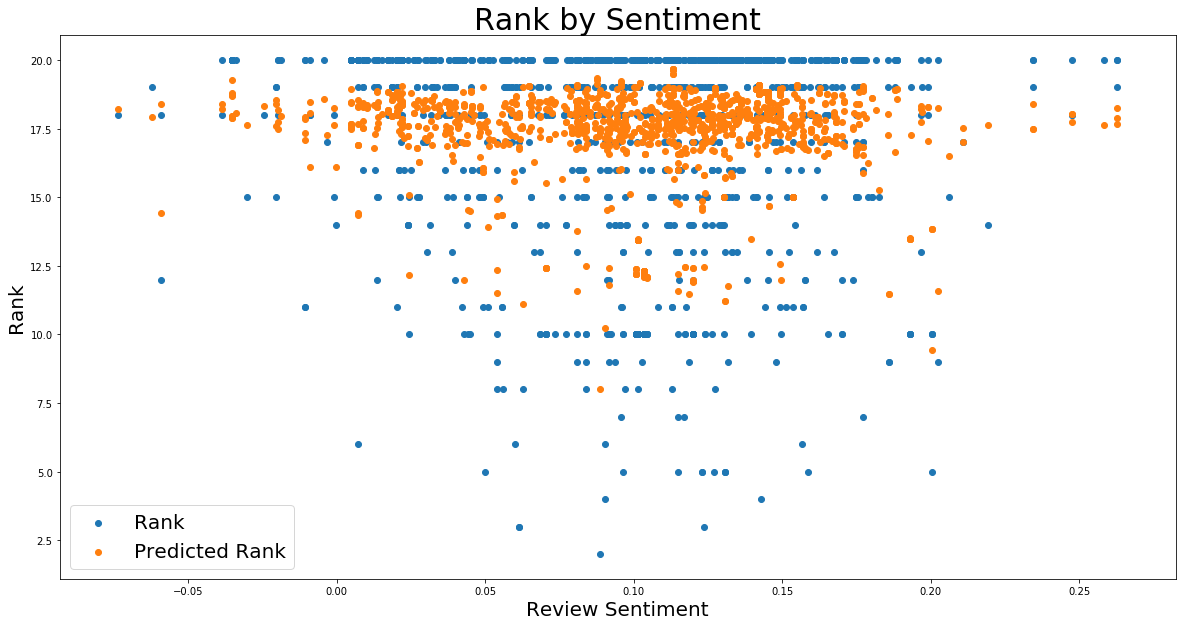

In [29]:
plt.figure(figsize = (20,10));
plt.scatter(x=df_dummy['sentiment'], y=df_dummy['rank'],label = 'Rank');
plt.scatter(x=df_dummy['sentiment'], y=df_dummy['pred_rank'], label = 'Predicted Rank')
plt.ylabel('Rank', fontsize = 20);
plt.xlabel('Review Sentiment', fontsize = 20);
plt.title('Rank by Sentiment', fontsize = 30);
plt.legend(fontsize = 20);

### Linear Regression with Cross Validation

(0.33987720365707985, 0.468712609183657)
(0.36765254466027053, 0.47349066236413556)
(0.3068827415098869, 0.5015903170983833)
(0.3100018301300007, 0.4721505389848286)
(0.34197022227835194, 0.4913329860072531)
(0.32724898507924216, 0.49824715033761197)
(0.30353281729685166, 0.5566200386285086)
(0.2928332160648217, 0.48044590666764697)
(0.30468001367045894, 0.5165142715218398)
(0.38037646901723976, 0.47745966571741394)


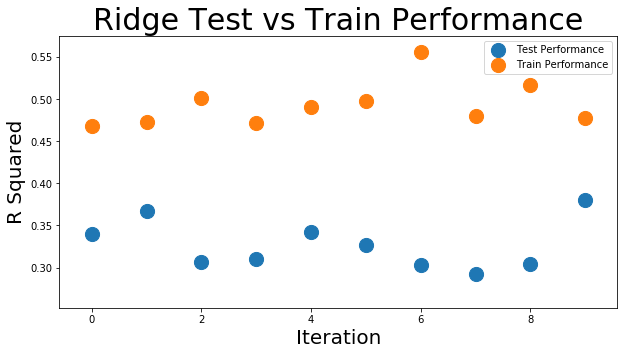

In [30]:
def lr_performance(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    lr = Ridge(fit_intercept=True, 
               normalize=True)
    lr.fit(X_train, y_train)
    return lr.score(X_test, y_test), lr.score(X_train, y_train)

def lr_test_train_iterations(X,y,z=10): 
    train_list = []
    test_list = []
    for i in range(z):
        result = lr_performance(X,y)
        print(result)
        train_list.append(result[1])
        test_list.append(result[0])
    plt.figure(figsize = (10,5));
    plt.scatter(x=[x for x in range(z)], 
            y=test_list,
            s=200,
            label = 'Test Performance')
    plt.scatter(x=[x for x in range(z)], 
             y=train_list,
             s=200,
             label = 'Train Performance')
    plt.ylabel('R Squared', fontsize = 20);
    plt.xlabel('Iteration', fontsize = 20);
    plt.title('Ridge Test vs Train Performance', fontsize = 30);
    plt.legend(fontsize = 10);

lr_test_train_iterations(X,y,10)

Clearly our model is very overfit, given the very poor performance of the test scores, compared with the train scores

### Get Top Coefficients

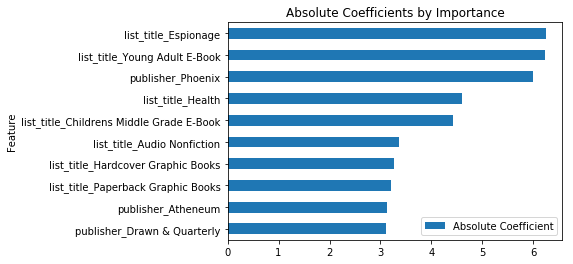

In [31]:
lr = Ridge(fit_intercept=True, 
           normalize=True)
lr.fit(X, y)

pd.DataFrame(sorted(zip(X.columns,[abs(x) for x in lr.coef_]),key = lambda x: x[1], reverse=True)[:10])\
            .rename(columns={0:'Feature',
                             1:'Absolute Coefficient'})\
            .set_index('Feature')[::-1]\
            .plot(kind='barh',
                  title='Absolute Coefficients by Importance')

### Random Forest Regresssion with Cross Validation

(0.4589401310317371, 0.8938926195659098)
(0.5652108675657269, 0.8858296896884806)
(0.3948040063359334, 0.8978018064384475)
(0.535492425106735, 0.9049995672104102)
(0.45486244862572334, 0.8785428497862918)
(0.4770589916241311, 0.9100952706378928)
(0.4831146389768584, 0.9018928721785032)
(0.5025357767269336, 0.8976958758543546)
(0.5003968408326556, 0.8774275449193742)
(0.37360576220403063, 0.9079661529395178)


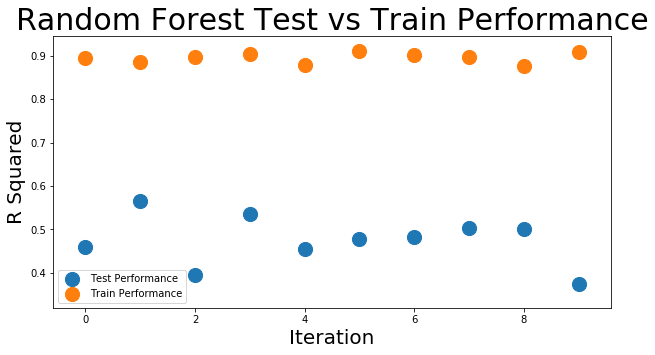

In [32]:
def rf_performance(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    rand_forest = RandomForestRegressor(n_estimators=5, 
                                        min_samples_split=2)
    rand_forest.fit(X_train, y_train)
    return rand_forest.score(X_test, y_test), rand_forest.score(X_train, y_train)

def rf_test_train_iterations(X,y,z=10): 
    train_list = []
    test_list = []
    for i in range(z):
        result = rf_performance(X,y)
        print(result)
        train_list.append(result[1])
        test_list.append(result[0])
    plt.figure(figsize = (10,5));
    plt.scatter(x=[x for x in range(z)], 
            y=test_list,
            s=200,
            label = 'Test Performance')
    plt.scatter(x=[x for x in range(z)], 
             y=train_list,
             s=200,
             label = 'Train Performance')
    plt.ylabel('R Squared', fontsize = 20);
    plt.xlabel('Iteration', fontsize = 20);
    plt.title('Random Forest Test vs Train Performance', fontsize = 30);
    plt.legend(fontsize = 10);
    
rf_test_train_iterations(X,y,10)

### Feature Importances

In [33]:
rand_forest = RandomForestRegressor(n_estimators=5, min_samples_split=2)
rand_forest.fit(X, y)
sorted(zip(X.columns,rand_forest.feature_importances_),key = lambda x: x[1], reverse=True)[:10]

[('weeks_on_list', 0.16845440319955618),
 ('review_length', 0.141042970264823),
 ('list_title_Picture Books', 0.09782454401625493),
 ('sentiment', 0.06528114708730773),
 ('list_title_Paperback Nonfiction', 0.034929284472287075),
 ('list_title_Trade Fiction Paperback', 0.03286824867111203),
 ('publisher_Houghton Mifflin Harcourt', 0.02958674024846929),
 ('list_title_Audio Nonfiction', 0.0270101313716274),
 ('list_title_Paperback Graphic Books', 0.022476074399099842),
 ('list_title_Hardcover Fiction', 0.021456427184956012)]

### Add Amazon Ranking Information

In [39]:
amazon_rank_df = pd.read_csv('https://raw.githubusercontent.com/jitsen-design/Data-607-Final-Project/master/data/masterrankings.csv',
                             usecols=[0,1,2,3,4,5]
)

### Merge Data with Original Dataframe

In [40]:
merge_df = pd.merge(amazon_rank_df,
             final_df,
             right_on='primary_isbn10',
             left_on='ASIN',
             how='left').dropna(subset=['sentiment'])

In [41]:
len(merge_df)

1600

We have only 38 unique samples, but let's run the models on htis set anyway!

In [42]:
len(merge_df['ASIN'].unique())

38

### Fit Regression Model and Get R^2 and Adjusted R^2

In [43]:
model_df2 = merge_df[['rank',
                      'GROUP',
                      'FORMAT',
                      'weeks_on_list',
                      'publisher',
                      'list_title',
                      'review_length',
                      'sentiment',
                      ]]

df_dummy2 = pd.get_dummies(model_df2, 
                          drop_first=False, 
                          columns=['publisher',
                                   'GROUP', 
                                   'FORMAT',
                                   'list_title'])

stats_model2 = Ridge(fit_intercept=True, normalize = True)
X2 = df_dummy2.drop(labels=['rank'],
                  axis=1)
y2 = df_dummy2['rank'] 
stats_model2.fit(X2, y2)
df_dummy2['pred_rank'] = stats_model2.predict(X2)
stats_model2.score(X2, y2), 1 - (1-stats_model2.score(X2, y2))*(len(y2)-1)/(len(y2)-X2.shape[1]-1)

(0.13383298260115095, 0.10123227720911121)

(0.1213812241876917, 0.12007318418653488)
(0.10123391848801921, 0.1431812811906319)
(0.09483517537122488, 0.14376569798911387)
(0.1087013019341928, 0.15765107934764233)
(0.10021927085797709, 0.15565870575733343)
(0.10512379517355343, 0.14200403840684062)
(0.0920048767294358, 0.13983929310970022)
(0.10264747577443302, 0.16204106158552634)
(0.09286957148963992, 0.16094872016536033)
(0.09732787098084916, 0.15146649116339805)


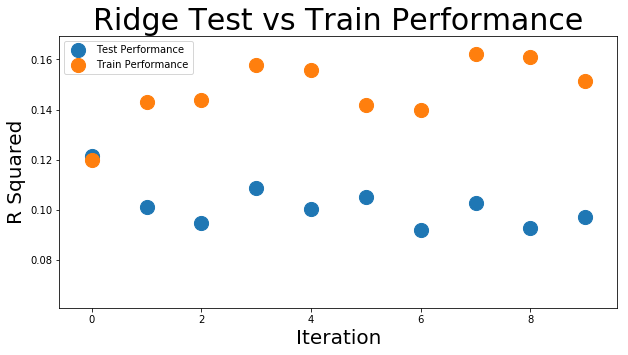

In [44]:
lr_test_train_iterations(X2,y2,10)

(0.6821825069176479, 0.800485142573743)
(0.5695879260241039, 0.8238020981593438)
(0.6210955735653818, 0.8178849789776107)
(0.6418083046261994, 0.8011137205487748)
(0.6392982381341517, 0.8024796235089646)
(0.6653548376438192, 0.8112732237313466)
(0.6470496253648144, 0.8096829766145671)
(0.6437496507908342, 0.8101951942162527)
(0.685962970516649, 0.7979091593710166)
(0.6302443120628072, 0.7951703298843427)


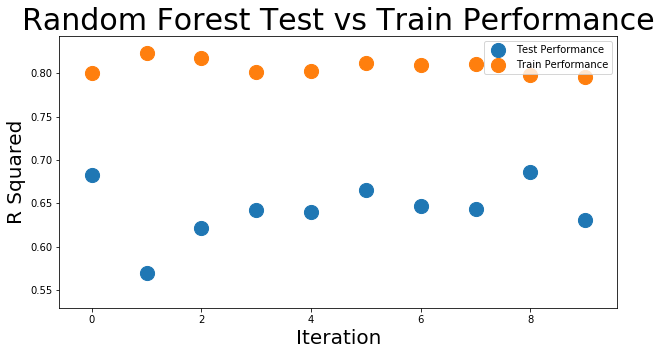

In [45]:
rf_test_train_iterations(X2,y2,10)

### Get Feature Importances

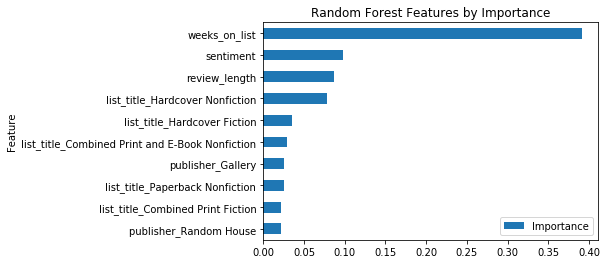

In [46]:
rand_forest2 = RandomForestRegressor(n_estimators=5, min_samples_split=2)
rand_forest2.fit(X2, y2)
pd.DataFrame(sorted(zip(X2.columns,rand_forest2.feature_importances_),key = lambda x: x[1], reverse=True)[:10])\
            .rename(columns={0:'Feature',
                             1:'Importance'})\
            .set_index('Feature')[::-1]\
            .plot(kind='barh',
                  title='Random Forest Features by Importance');

### Get Sentiment Ranks by Book Type

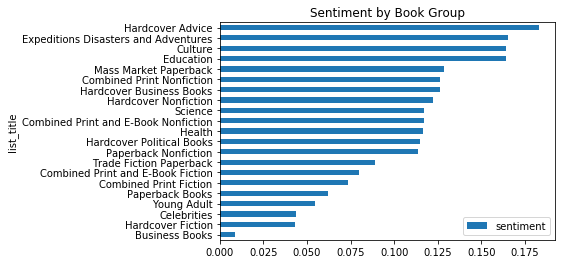

In [47]:
merge_df.groupby('list_title').agg({'sentiment':'mean'})\
                              .sort_values(by='sentiment')\
                              .plot(kind='barh',
                                    title='Sentiment by Book Group'
                                    
                              );